[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/jfcrenshaw/pzflow/blob/main/examples/redshift_example.ipynb)

If running in Colab, to switch to GPU, go to the menu and select Runtime -> Change runtime type -> Hardware accelerator -> GPU.

In addition, uncomment and run the following code:

In [1]:
# !pip install pzflow corner

-------------------
## Redshift example

This example notebook demonstrates `pzflow` in higher dimensions, as well as gives an example of constructing a more complicated bijector.
These are demonstrated on a a 7-dimensional distribution of galaxy redshift data.
For more basic `pzflow` usage, see the [intro notebook](https://github.com/jfcrenshaw/pzflow/blob/main/examples/intro.ipynb).

In [1]:
import jax.numpy as np
import matplotlib.pyplot as plt
import corner

import pzflow
from pzflow import Flow
from pzflow.bijectors import Chain, InvSoftplus, StandardScaler, RollingSplineCoupling
from pzflow.examples import get_galaxy_data

First let's load the example galaxy data set included with `pzflow`.

In [2]:
data = get_galaxy_data()
data.head()

,redshift,u,g,r,i,z,y
0,0.287087,26.759261,25.901778,25.187710,24.932318,24.736903,24.671623
1,0.293313,27.428358,26.679299,25.977161,25.700094,25.522763,25.417632
2,1.497276,27.294001,26.068798,25.450055,24.460507,23.887221,23.206112
3,0.283310,28.154075,26.283166,24.599570,23.723491,23.214108,22.860012
4,1.545183,29.276065,27.878301,27.333528,26.543374,26.061941,25.383056


You can see the first column is redshift, and the subsequent columns are galaxy magnitudes in the 6 LSST bandpass filters. 
Do not worry if you are unfamiliar with this kind of data - the astronomy details are not important for understanding this notebook.

Notice that the data is in a Pandas DataFrame, which is the data format `pzflow` uses on the user-end.

Now we will build a Flow to model this data.
First we must construct the bijector.
Note when designing bijectors, it is important to remember that pzflow defines the forward bijection as the map from the data distribution to the latent distribution.

Our bijector consists of four parts:

**1. Inverse Softplus** --  
This bijector applies the inverse of the softplus transformation to the requested columns.
We will apply this to the redshift column.
This is useful as the Inverse Softplus maps the domain $[0, \infty)$ onto the range $(-\infty, \infty)$, thus relaxing the positive-only constraint on the redshift.
You can also think of this in the inverse direction: when you sample from the Flow, a softplus transformation is applied to the redshift, ensuring that sampled redshifts are always positive.

**2. Standard Scaler** --  
This bijector scales the data so that they have mean zero and unit variance.
This makes training easier and more stable.
Note that technically we need to provide the mean and standard deviation of the redshifts after they have had the Inverse Softplus applied, since that bijector is applied before this one.
However, as we will us a very sharp softplus, this technicality can be ignored.

**3. Rolling Spline Coupling** --  
Finally, this is the bijection that performs the heavy lifting of mapping the data distribution onto the latent distribution.
This bijector alternates [Neural Spline Couplings](https://arxiv.org/abs/1906.04032) and "Rolling" layers. It has 5 parameters:
- `nlayers` - The number of (Neural Spline, Roll()) couplets in the chain of bijectors
- `K` - The number of bins in the splines
- `B` - The range of the splines
- `hidden_layers` - the number of hidden layers in the neural network that calculates the spline bins and derivatives
- `hidden_dim` - the number of hidden dimensions in that same neural network
- `transformed_dim` - the number of dimensions transformed by the spline
- `n_conditionas` - the number of variables you are conditioning the bijector on. See the [conditional example](https://github.com/jfcrenshaw/pzflow/blob/main/examples/conditional_redshift_example.ipynb) for more details.

Only `nlayers` is required.
For this example, we will set `nlayers` = 7 to match the input dimension, and we will leave everything else to their default values.
Feel free to play around with changing the other parameters.

We construct the total bijector by chaining these three bijectors together.

In [3]:
# set the inverse softplus parameters, 
# to ensure that sampled redshifts are positive
column_idx = 0
sharpness = 10

# calculate the mean and standard deviations of the dimensions
means = data.mean(axis=0).values
stds = data.std(axis=0).values

# set number of layers in the RollingSplineCoupling
# equal to the input dimension
nlayers = data.shape[1]

# construct our bijector
# by chaining all these layers
bijector = Chain(
    InvSoftplus(column_idx, sharpness),
    StandardScaler(means, stds),
    RollingSplineCoupling(nlayers),
)

Some additional notes about the bijector:
- The InverseSoftplus and Standard Scaler layers in our bijector are essentially pre-processing the data. We build these into the bijector so that we can work directly in the space of the original data, and so that when we sample from the Flow, it automatically produces samples in the original data space. However, if you have some custom pre-processing you want to perform but don't want to build into a bijector, you can of course just do that manually and then train the Flow on the pre-processed data. However, in that case, don't forget that when you sample from the Flow, the samples will be "pre-processed", and thus you will need to manually undo the pre-processing if you want samples in the original data space. 
- The first two layers in this bijector are column specific, which requires us to keep track of which variable is in which column of our data. The order of the columns in the bijector must match the order of the column names we give the normalizing flow on instantiation (see below). However, constructing the bijector is the *ONLY* time you have to keep track of column ordering. This is because the flow works with pandas dataframes, and it uses the column names you provide at instantiation to ensure the data is ordered correctly for the bijector.

Now that we have created a bijector, we can instantiate the flow with the `Flow` object.
We have to give it the names of the columns in our data set, as well as the bijector we just created.

In [4]:
# To create the normalizing flow, we have to provide
# 1. The names of the columns in our data set
# 2. The bijector
flow = Flow(data.columns, bijector)

Note that by default, the flow uses a Normal distribution as the latent distribution. If you wanted, you could set `latent=Tdist(input_dim=7)` at instantiation.
This tells the flow to use a t-distribution as the latent distribution, and to learn the weight of the tails during training. This could be helpful if you are learning a distribution with heavy tails. You can also use a `Uniform` or `CentBeta` distribution if you are modeling data with a compact domain. You can also use `Joint` to build a joint latent distribution out of any of these building blocks. For an example of the latter two use cases, see [the example on building a flow with periodic topology](https://colab.research.google.com/github/jfcrenshaw/pzflow/blob/main/examples/spherical_flow_example.ipynb).

Now we can train our normalizing flow.
This is as simple as calling `flow.train(data)`.
There are several training parameters you can set, including the number of epochs, the batch size, the optimizer, and the random seed.
See the normalizing flow documentation for more details.
For this example, let's set `epochs=200` and `verbose=True`.

*Warning:* this takes about 25 minutes to run on my CPU. (but only 2 minutes on a GPU!)

In [5]:
%%time
losses = flow.train(data, epochs=200, verbose=True)

Training 200 epochs 
Loss:
(0) 13.6907
(1) 0.2077
(11) -3.9389
(21) -4.0815
(31) -4.7338
(41) -5.1403
(51) -5.4921
(61) -5.9330
(71) -5.0861
(81) -5.8870
(91) -5.7432
(101) -6.0967
(111) -5.6096
(121) -6.5060
(131) -6.3541
(141) -6.6064
(151) -6.6780
(161) -5.9015
(171) -6.7629
(181) -6.6896
(191) -6.7359
(200) -7.0668
CPU times: user 2min 42s, sys: 1min 55s, total: 4min 38s
Wall time: 1min 48s


Now let's plot the training losses to make sure everything looks like we expect it to...

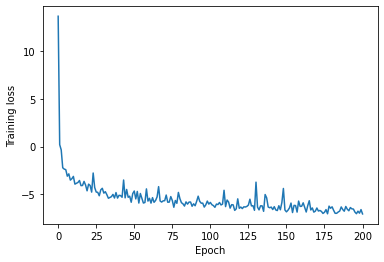

In [6]:
plt.plot(losses)
plt.xlabel("Epoch")
plt.ylabel("Training loss")
plt.show()

Great!

Now we can draw samples from the flow, using the `sample` method.
Let's draw 10000 samples and make a corner plot, comparing these samples to the training set.

In [7]:
samples = flow.sample(10000, seed=0)

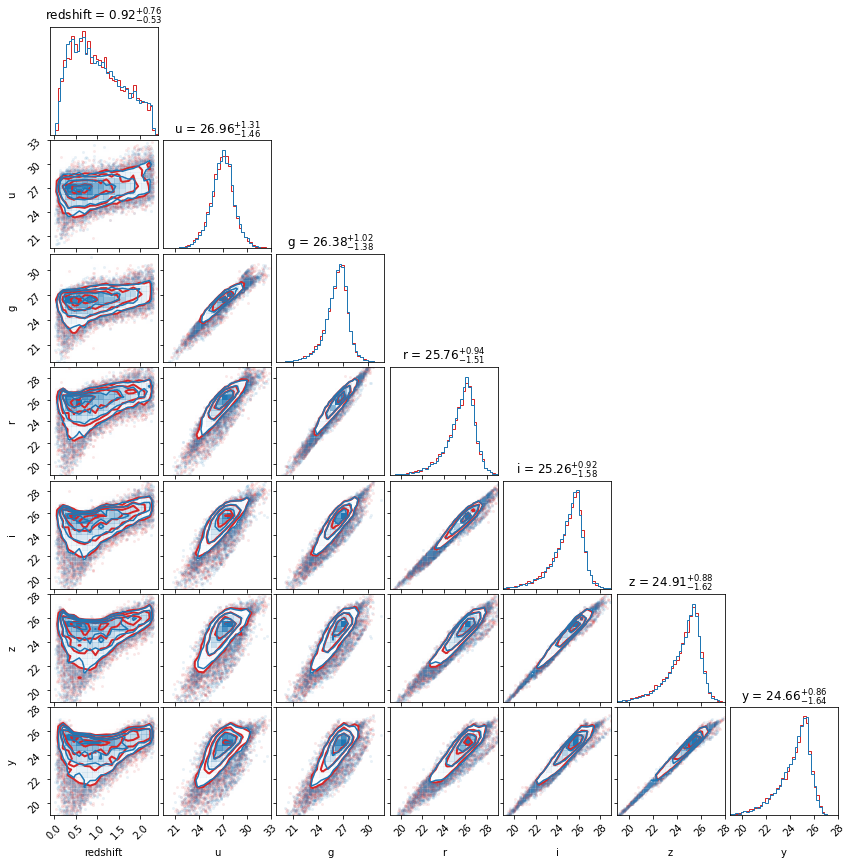

In [8]:
fig = plt.figure(figsize=(12,12))

ranges = [(-0.1,2.4), (19.5,33), (19,32), (19,29), (19,29), (19,28), (19,28)]

corner.corner(samples, fig=fig, color='C3', bins=20, range=ranges, hist_bin_factor=2, data_kwargs={'ms':3}, contour_kwargs={'linewidths':2})

corner.corner(data[:10000], fig=fig, bins=20, range=ranges, hist_bin_factor=2, color='C0', data_kwargs={'ms':3}, show_titles=True);

Looks great!

We can also use the flow to calculate redshift posteriors for galaxies using the `posterior` method.

In [9]:
grid = np.arange(0, 2.02, 0.02)
pdfs = flow.posterior(samples, column="redshift", grid=grid)

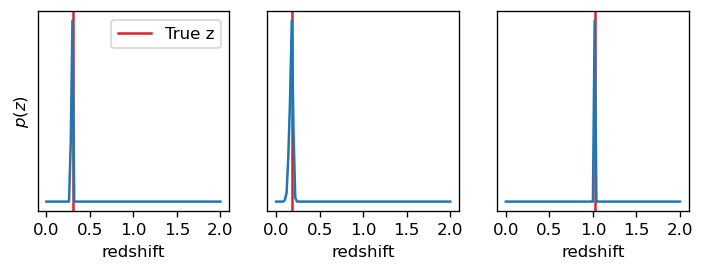

In [10]:
fig, axes = plt.subplots(1,3,figsize=(7,2.2), dpi=120)

idx = [9, 14, 227]
for i,ax in zip(idx, axes):
    true_z = samples['redshift'][i]
    ax.axvline(true_z, 0, 1, c="C3",
               label='True z')
    ax.plot(grid, pdfs[i])
    ax.set(xlabel="redshift",
           xticks=[0,0.5,1,1.5,2],
           yticks=[])
axes[0].legend()
axes[0].set(ylabel='$p(z)$')
plt.show()

We can also draw posteriors for magnitudes.
For example, lets draw posteriors for the $u$ band:

In [11]:
u_grid = np.arange(21, 30, 0.1)
u_pdfs = flow.posterior(samples, column='u', grid=u_grid)

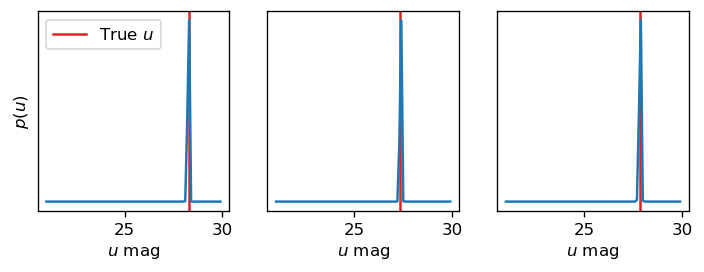

In [12]:
fig, axes = plt.subplots(1,3,figsize=(7,2.2), dpi=120)

idx = [1, 24, 117]
for i,ax in zip(idx, axes):
    true_u = samples['u'][i]
    ax.axvline(true_u, 0, 1, c="C3",
               label='True $u$')
    ax.plot(u_grid, u_pdfs[i])
    ax.set(xlabel="$u$ mag", 
           yticks=[])
axes[0].legend()
axes[0].set(ylabel='$p(u)$')
plt.show()

Now let's store some information with the flow about the data it was trained on.

In [13]:
flow.info = f"""
This is an example flow, trained on 100,000 simulated galaxies with 
redshifts in the range (0, 2.3) and photometry in the LSST ugrizy bands.

The data set used to train this flow is available in the `examples` module:
>>> from pzflow.examples import get_galaxy_data
>>> data = get_galaxy_data()

This flow was created with pzflow version {pzflow.__version__}
"""

In [14]:
print(flow.info)


This is an example flow, trained on 100,000 simulated galaxies with 
redshifts in the range (0, 2.3) and photometry in the LSST ugrizy bands.

The data set used to train this flow is available in the `examples` module:
>>> from pzflow.examples import get_galaxy_data
>>> data = get_galaxy_data()

This flow was created with pzflow version 2.0.0



Now let's save the flow to a file that can be loaded later:

In [15]:
flow.save("example_flow.pzflow.pkl")

This file can be loaded on Flow instantiation:

In [16]:
flow = Flow(file="example_flow.pzflow.pkl")

This example flow is also packaged with `pzflow`, so you can load it and play with it whenever you want:

In [1]:
from pzflow.examples import get_example_flow
flow = get_example_flow()

See! It's the same one:

In [2]:
print(flow.info)


This is an example flow, trained on 100,000 simulated galaxies with 
redshifts in the range (0, 2.3) and photometry in the LSST ugrizy bands.

The data set used to train this flow is available in the `examples` module:
>>> from pzflow.examples import get_galaxy_data
>>> data = get_galaxy_data()

This flow was created with pzflow version 2.0.0

